In [1]:
pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 166.0/166.0 kB 5.0 MB/s eta 0:00:00


In [2]:
from hmmlearn import hmm
import numpy as np
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
ticker = '^SPX'
data = yf.download(ticker, period='10y')
data

/tmp/ipython-input-2388120531.py:2: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, period='10y')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,^SPX,^SPX,^SPX,^SPX,^SPX
Date,,,,,
2016-01-19,1881.329956,1901.439941,1864.599976,1888.660034,4928350000
2016-01-20,1859.329956,1876.180054,1812.290039,1876.180054,6416070000
2016-01-21,1868.989990,1889.849976,1848.979980,1861.459961,5078810000
2016-01-22,1906.900024,1908.849976,1877.400024,1877.400024,4901760000
2016-01-25,1877.079956,1906.280029,1875.969971,1906.280029,4401380000
...,...,...,...,...,...
2026-01-12,6977.270020,6986.330078,6934.069824,6944.120117,5019040000
2026-01-13,6963.740234,6985.830078,6938.770020,6977.410156,5091730000


In [4]:
market_data = pd.DataFrame({'close': data[('Close', ticker)]}, index=data.index)
market_data.head()

,close
Date,
2016-01-19,1881.329956
2016-01-20,1859.329956
2016-01-21,1868.989990
2016-01-22,1906.900024
2016-01-25,1877.079956


In [5]:
market_data['returns'] = market_data['close'].pct_change()
market_data.dropna(inplace=True)
market_data

,close,returns
Date,,
2016-01-20,1859.329956,-0.011694
2016-01-21,1868.989990,0.005195
2016-01-22,1906.900024,0.020284
2016-01-25,1877.079956,-0.015638
2016-01-26,1903.630005,0.014144
...,...,...
2026-01-12,6977.270020,0.001578
2026-01-13,6963.740234,-0.001939
2026-01-14,6926.600098,-0.005333


In [6]:
print("\nPreparing data for HMM training...")

returns = market_data['returns'].dropna()
X_cont = returns.values

print(f"Log returns calculated: {len(returns)} data points")
print(f"Data shape: {X_cont.shape}")


Preparing data for HMM training...
Log returns calculated: 2514 data points
Data shape: (2514,)


In [7]:
q1, q2 = -0.005, 0.005

def categorize(r):
    if r <= q1:
        return 0
    elif r <= q2:
        return 1
    return 2

regimes = np.array([categorize(r) for r in X_cont])

X = regimes.reshape(-1, 1)

print("\nRegime thresholds:")
print(f"  Bear: <= {q1:.6f}")
print(f"  Stagnant: <= {q2:.6f}")
print(f"  Bull: > {q2:.6f}")
print(f"Samples in each regime: {np.bincount(regimes)}")


Regime thresholds:
  Bear: <= -0.005000
  Stagnant: <= 0.005000
  Bull: > 0.005000
Samples in each regime: [ 531 1276  707]


In [8]:
model = hmm.CategoricalHMM(
    n_components=3,
    n_iter=100,
    random_state=42,
    init_params="mcst",
    verbose=False
)

print("\nTraining HMM using Baum-Welch algorithm...")
try:
    model.fit(X)
    print("✓ HMM training completed")
    print(f"  Converged in {model.monitor_.iter} iterations")
    print(f"  Final log-likelihood: {model.score(X):.3f}")

except Exception as e:
    print(f"X Training failed: {e}")


Training HMM using Baum-Welch algorithm...
✓ HMM training completed
  Converged in 28 iterations
  Final log-likelihood: -2479.890


In [9]:
print("\nStep 4.2.3: Regime Detection using Viterbi Algorithm")

print("Applying Viterbi algorithm to find the most likely sequence of hidden states...")


print("Running Viterbi algorithm...")
hidden_states = model.predict(X)

print("✓ Viterbi algorithm completed successfully")
print(f"Most likely sequence: {len(hidden_states)} hidden states")


Step 4.2.3: Regime Detection using Viterbi Algorithm
Applying Viterbi algorithm to find the most likely sequence of hidden states...
Running Viterbi algorithm...
✓ Viterbi algorithm completed successfully
Most likely sequence: 2514 hidden states


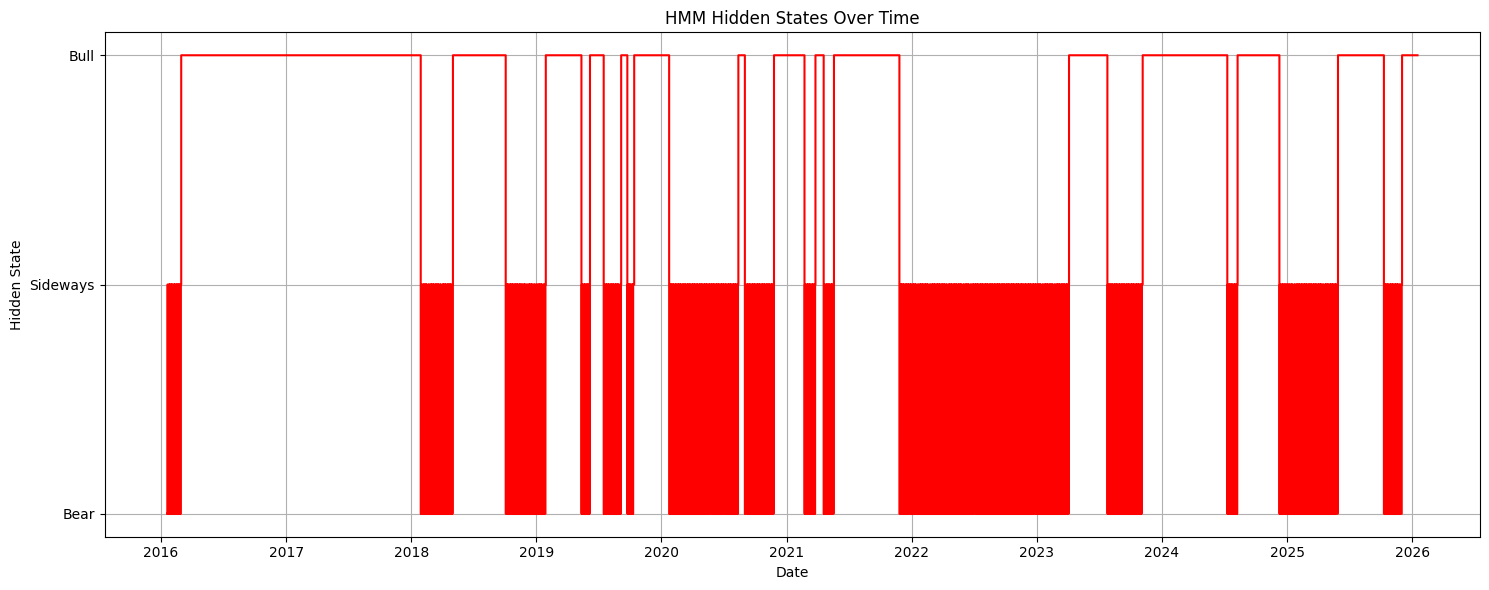

In [10]:
from matplotlib.typing import ColourType

time_index = market_data.index


plt.figure(figsize=(15, 6))
plt.plot(time_index, hidden_states, drawstyle='steps-post', color='red')
plt.title('HMM Hidden States Over Time')
plt.xlabel('Date')
plt.ylabel('Hidden State')
plt.yticks([0, 1, 2], ['Bear', 'Sideways', 'Bull'])
plt.grid(True)
plt.tight_layout()
plt.show()

In [11]:
print("Creating plot_df and adding 'regime' column...")
plot_df = market_data.copy()
plot_df['regime'] = hidden_states

print("✓ plot_df created with 'regime' column.")
print("First 5 rows of plot_df:")
plot_df.head()

Creating plot_df and adding 'regime' column...
✓ plot_df created with 'regime' column.
First 5 rows of plot_df:


,close,returns,regime
Date,,,
2016-01-20,1859.329956,-0.011694,0
2016-01-21,1868.989990,0.005195,1
2016-01-22,1906.900024,0.020284,0
2016-01-25,1877.079956,-0.015638,1
2016-01-26,1903.630005,0.014144,0


Generating plot of Nifty 50 Close Price with HMM Regimes...


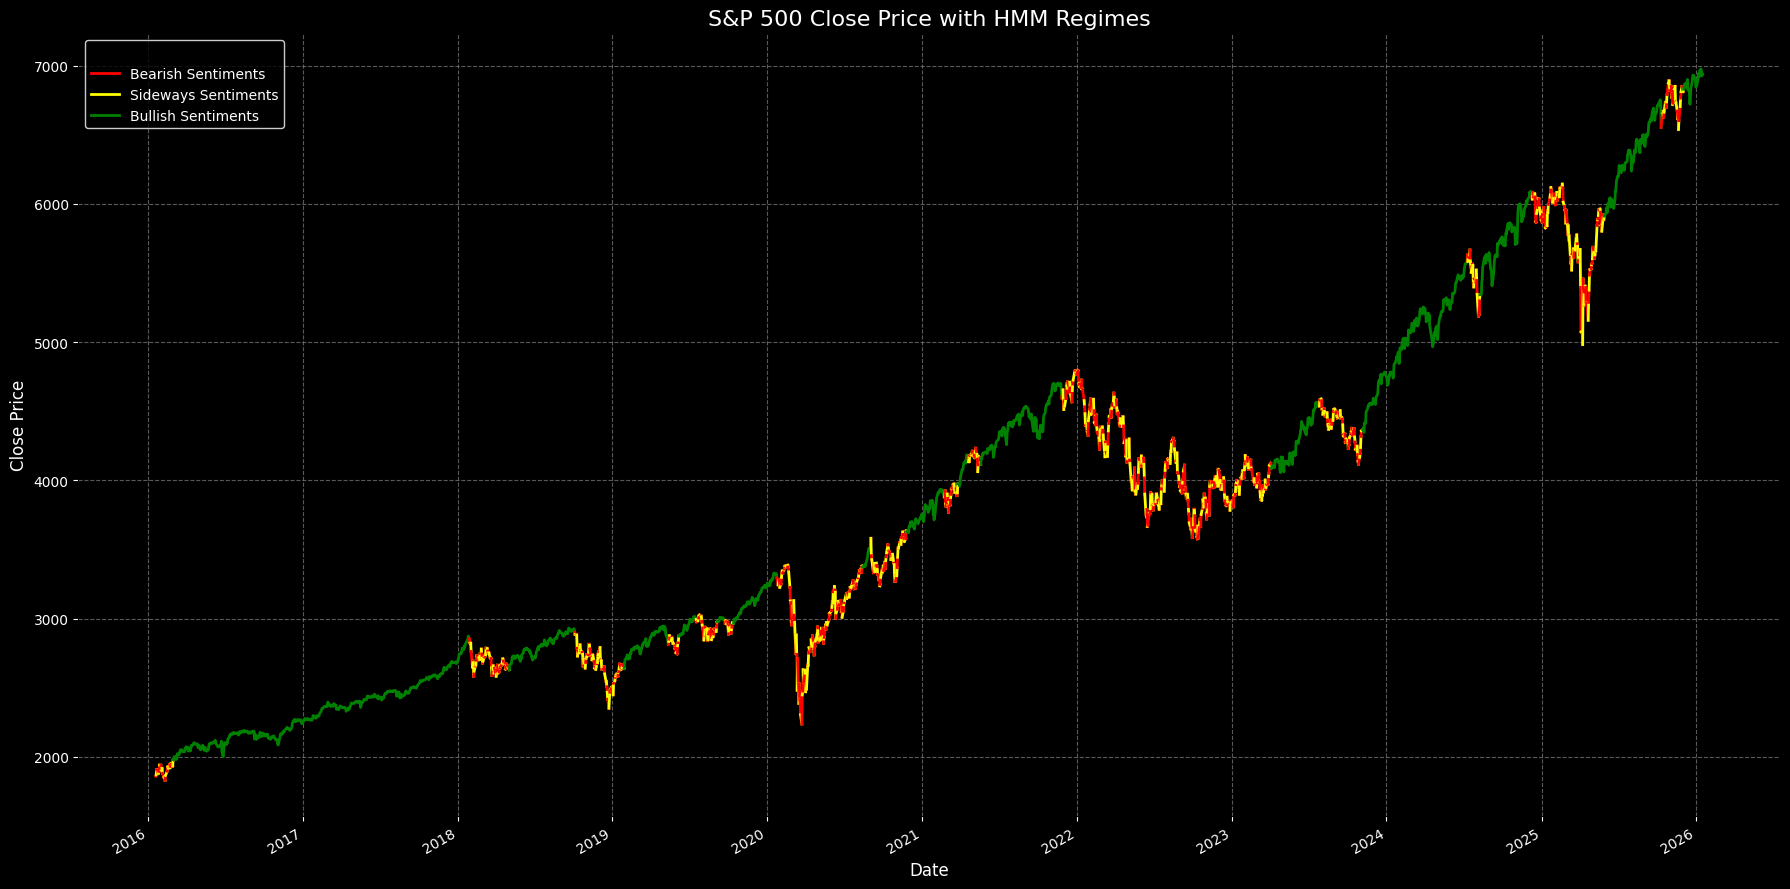

✓ Plot generated successfully.


In [12]:


regime_colors = {
    0: {'name': 'Bearish Sentiments', 'color': 'red'},
    1: {'name': 'Sideways Sentiments', 'color': 'yellow'},
    2: {'name': 'Bullish Sentiments', 'color': 'green'}
}

print("Generating plot of Nifty 50 Close Price with HMM Regimes...")


fig = plt.figure(figsize=(18, 9))
ax = fig.add_subplot(111)


fig.patch.set_facecolor('black')
ax.set_facecolor('black')


plotted_regimes = set()


start_idx = 0
for i in range(1, len(plot_df)):

    if plot_df['regime'].iloc[i] != plot_df['regime'].iloc[start_idx] or i == len(plot_df) - 1:

        if i == len(plot_df) - 1 and plot_df['regime'].iloc[i] == plot_df['regime'].iloc[start_idx]:
            segment_df = plot_df.iloc[start_idx : i + 1]
        else:

            segment_df = plot_df.iloc[start_idx : i + 1]


        current_regime_id = plot_df['regime'].iloc[start_idx]
        color_info = regime_colors[current_regime_id]
        label = color_info['name'] if current_regime_id not in plotted_regimes else "_nolegend_"

        ax.plot(segment_df.index, segment_df['close'],
                color=color_info['color'], label=label, linewidth=2)
        plotted_regimes.add(current_regime_id)


        start_idx = i


ax.set_title('S&P 500 Close Price with HMM Regimes', fontsize=16, color='white')


ax.set_xlabel('Date', fontsize=12, color='white')
ax.set_ylabel('Close Price', fontsize=12, color='white')


ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')


ax.legend(title='Market Regimes', facecolor='black', edgecolor='white', labelcolor='white')


ax.grid(True, linestyle='--', alpha=0.7, color='grey')


fig.autofmt_xdate()


plt.tight_layout()
plt.show()

print("✓ Plot generated successfully.")


In [13]:
print("\nGrouping plot_df by regime and calculating statistics:\n")


regime_stats = plot_df.groupby('regime')['returns'].agg(['mean', 'std'])


regime_names_map = {key: value['name'] for key, value in regime_colors.items()}

print("Regime Summary:")
summary_data = []
for num_regime, stats in regime_stats.iterrows():
    label = regime_names_map[num_regime]
    mean_return = stats['mean']
    std_dev = stats['std']


    sharpe_ratio = mean_return / std_dev if std_dev != 0 else np.nan

    summary_data.append({
        'Regime Label': label,
        'Mean Returns': f"{mean_return:.6f}",
        'Volatility': f"{std_dev:.6f}",
        'Sharpe Ratio': f"{sharpe_ratio:.6f}" if not np.isnan(sharpe_ratio) else "N/A"
    })

summary_df = pd.DataFrame(summary_data, index=regime_stats.index)
print(summary_df)



Grouping plot_df by regime and calculating statistics:

Regime Summary:
               Regime Label Mean Returns Volatility Sharpe Ratio
regime                                                          
0        Bearish Sentiments     0.000056   0.015828     0.003537
1       Sideways Sentiments    -0.000552   0.016103    -0.034254
2        Bullish Sentiments     0.001203   0.005963     0.201719


In [14]:
print("\n" + "="*50)
print("LEARNED CATEGORICAL HMM PARAMETERS")
print("="*50)

hidden_states = model.predict(X)


print("\n1. EMISSION PROBABILITIES (what each regime emits):")
print("   Rows = Hidden states, Columns = Observed return category (0=Bear,1=Sideways,2=Bull)")
for i, probs in enumerate(model.emissionprob_):
    print(f"   State {i}: {probs}")

state_names = ["Bear", "Sideways", "Bull"]


print("\n2. TRANSITION MATRIX (probability of regime switching):")
print("   Rows = From State, Columns = To State")
print(model.transmat_)


print("\n   Expected duration in each state:")
for i in range(model.n_components):
    p = model.transmat_[i, i]
    duration = 1 / (1 - p) if p < 1 else float("inf")
    print(f"   State {i} ({state_names[i]}): {duration:.2f} periods")


print("\n3. START PROBABILITIES:")
for i, p in enumerate(model.startprob_):
    print(f"   State {i}: {p:.4f}")


print("\n4. STATE-CONDITIONAL RETURN STATISTICS:")
for state in range(model.n_components):
    idx = hidden_states == state
    count = np.sum(idx)
    state_ret = returns[idx]

    print(f"\n   State {state} ({state_names[state]}):")
    print(f"     - Frequency: {count} samples ({count/len(returns)*100:.1f}%)")
    print(f"     - Mean return: {state_ret.mean():.6f}")
    print(f"     - Std dev: {state_ret.std():.6f}")


logL = model.score(X)
print("\n5. MODEL QUALITY:")
print(f"   Log Likelihood: {logL:.4f}")

n_states = model.n_components
n_observations = len(np.unique(X))

n_params = (
    (n_states - 1) +
    n_states * (n_states - 1) +
    n_states * (n_observations - 1)
)

AIC = -2 * logL + 2 * n_params
BIC = -2 * logL + np.log(len(X)) * n_params

print(f"   Num. parameters: {n_params}")
print(f"   AIC: {AIC:.4f}")
print(f"   BIC: {BIC:.4f}")


print("\n6. SAVING MODEL:")
import joblib
joblib.dump(model, "categorical_hmm_model.pkl")
print("   ✓ Saved as categorical_hmm_model.pkl")

print("\n" + "="*50)
print("CATEGORICAL HMM TRAINING COMPLETE")
print("="*50)


LEARNED CATEGORICAL HMM PARAMETERS

1. EMISSION PROBABILITIES (what each regime emits):
   Rows = Hidden states, Columns = Observed return category (0=Bear,1=Sideways,2=Bull)
   State 0: [0.33892713 0.30512428 0.35594859]
   State 1: [0.34061894 0.28695419 0.37242687]
   State 2: [0.10024207 0.69022709 0.20953084]

2. TRANSITION MATRIX (probability of regime switching):
   Rows = From State, Columns = To State
[[1.84099926e-03 9.98072914e-01 8.60871237e-05]
 [9.25877895e-01 1.40781220e-02 6.00439828e-02]
 [2.08206244e-02 4.75369847e-03 9.74425677e-01]]

   Expected duration in each state:
   State 0 (Bear): 1.00 periods
   State 1 (Sideways): 1.01 periods
   State 2 (Bull): 39.10 periods

3. START PROBABILITIES:
   State 0: 1.0000
   State 1: 0.0000
   State 2: 0.0000

4. STATE-CONDITIONAL RETURN STATISTICS:

   State 0 (Bear):
     - Frequency: 536 samples (21.3%)
     - Mean return: 0.000056
     - Std dev: 0.015828

   State 1 (Sideways):
     - Frequency: 536 samples (21.3%)
     

In [15]:
print("\nStep 4.2.3: Regime Detection using Viterbi Algorithm")

print("Applying Viterbi algorithm to find the most likely sequence of hidden states...")


print("Running Viterbi algorithm...")
hidden_states = model.predict(X)

print("✓ Viterbi algorithm completed successfully")
print(f"Most likely sequence: {len(hidden_states)} hidden states")

price_series = market_data["close"]


print("\nCreating regime analysis dataframe...")
price_with_regimes = pd.DataFrame({
    "close": price_series.values,
    'Returns': returns.values,
    'Price_Diff': price_series.diff().values,
    'Regime_Raw': hidden_states
}, index=price_series.index)

print(f"Regime dataframe created: {price_with_regimes.shape}")
print(f"Date range: {price_with_regimes.index.min()} to {price_with_regimes.index.max()}")


print("\nInitial Regime Distribution (Raw States):")
regime_counts_raw = pd.Series(hidden_states).value_counts().sort_index()
for regime, count in regime_counts_raw.items():
    percentage = count / len(hidden_states) * 100
    mean_return = price_with_regimes[price_with_regimes['Regime_Raw'] == regime]['Returns'].mean()
    print(f"  State {regime}: {count} observations ({percentage:.1f}%), mean return: {mean_return:.6f})")


print("\nCalculating state interpretations based on mean returns...")
regime_means = price_with_regimes.groupby('Regime_Raw')['Returns'].mean()
print("Mean returns by raw state:")
for regime, mean_return in regime_means.items():
    print(f"  State {regime}: {mean_return:.6f} (annualized: {mean_return*12*100:.2f}%)वरुन")



print("\nMapping raw states to economic regimes...")
sorted_regimes = regime_means.sort_values().index.tolist()
regime_mapping = {
    sorted_regimes[0]: 0,
    sorted_regimes[1]: 1,
    sorted_regimes[2]: 2
}

print(f"Raw state mapping: {regime_mapping}")
print("Interpretation:")
for raw_state, mapped_state in regime_mapping.items():
    mean_return = regime_means[raw_state]
    label = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}[mapped_state]
    print(f"  Raw State {raw_state} → {label} (mean return: {mean_return:.6f})")


price_with_regimes['Regime'] = price_with_regimes['Regime_Raw'].map(regime_mapping)


print("\nVerifying regime mapping...")
final_means = price_with_regimes.groupby('Regime')['Returns'].mean()
regime_labels = {0: 'Bear', 1: 'Sideways', 2: 'Bull'}

print("Final Regime Distribution:")
for regime in [0, 1, 2]:
    regime_data = price_with_regimes[price_with_regimes['Regime'] == regime]
    count = len(regime_data)
    percentage = count / len(price_with_regimes) * 100
    mean_return = final_means[regime]
    std_return = regime_data['Returns'].std()

    print(f"  {regime_labels[regime]} Market (State {regime}):")
    print(f"    - Observations: {count} ({percentage:.1f}%)")
    print(f"    - Mean return: {mean_return:.6f}")
    print(f"    - Return volatility: {std_return:.6f}")
    if std_return > 0:
        sharpe = mean_return / std_return
        print(f"    - Sharpe ratio: {sharpe:.4f}")


print("\nAnalyzing regime transitions...")


regime_changes = (price_with_regimes['Regime'] != price_with_regimes['Regime'].shift(1))
regime_periods = regime_changes.cumsum()


print("Regime Duration Analysis:")
duration_stats = []
for regime in [0, 1, 2]:
    regime_data = price_with_regimes[price_with_regimes['Regime'] == regime]
    regime_periods_subset = regime_periods[price_with_regimes['Regime'] == regime]

    period_lengths = regime_periods_subset.value_counts().values

    if len(period_lengths) > 0:
        avg_duration = period_lengths.mean()
        max_duration = period_lengths.max()
        min_duration = period_lengths.min()
        num_periods = len(period_lengths)

        print(f"  {regime_labels[regime]} Market:")
        print(f"    - Number of periods: {num_periods}")
        print(f"    - Average duration: {avg_duration:.1f} months")
        print(f"    - Longest period: {max_duration} months")
        print(f"    - Shortest period: {min_duration} months")

        duration_stats.append({
            'Regime': regime_labels[regime],
            'Num_Periods': num_periods,
            'Avg_Duration': avg_duration,
            'Max_Duration': max_duration,
            'Min_Duration': min_duration
        })


print("\nEmpirical Transition Probabilities:")
transition_counts = np.zeros((3, 3))

for i in range(1, len(price_with_regimes)):
    from_state = price_with_regimes['Regime'].iloc[i-1]
    to_state = price_with_regimes['Regime'].iloc[i]
    transition_counts[from_state, to_state] += 1


transition_probs = transition_counts / transition_counts.sum(axis=1, keepdims=True)

print("   From\\To    Bear   Sideways   Bull")
print("   " + "-" * 35)
for i in range(3):
    row = [f"{transition_probs[i, j]:8.3f}" for j in range(3)]
    print(f"   {regime_labels[i]:<8} {' '.join(row)}")


print("\nComparison with Model's Learned Transition Probabilities:")
print("   From\\To    Bear   Sideways   Bull")
print("   " + "-" * 35)
for i in range(3):
    learned_row = [f"{model.transmat_[i, j]:8.3f}" for j in range(3)]
    print(f"   {regime_labels[i]:<8} {' '.join(learned_row)}")


print("\nIdentifying Major Regime Periods...")
major_periods = []

current_regime = price_with_regimes['Regime'].iloc[0]
start_date = price_with_regimes.index[0]
duration = 1


price_column = 'close'

for i in range(1, len(price_with_regimes)):
    if price_with_regimes['Regime'].iloc[i] == current_regime:
        duration += 1
    else:

        end_date = price_with_regimes.index[i-1]
        major_periods.append({
            'Regime': regime_labels[current_regime],
            'Start_Date': start_date,
            'End_Date': end_date,
            'Duration': duration,
            'Total_Return': (price_with_regimes[price_column].iloc[i-1] / price_with_regimes[price_column].iloc[i-duration] - 1) * 100
        })


        current_regime = price_with_regimes['Regime'].iloc[i]
        start_date = price_with_regimes.index[i]
        duration = 1


end_date = price_with_regimes.index[-1]
major_periods.append({
    'Regime': regime_labels[current_regime],
    'Start_Date': start_date,
    'End_Date': end_date,
    'Duration': duration,
    'Total_Return': (price_with_regimes[price_column].iloc[-1] / price_with_regimes[price_column].iloc[-duration] - 1) * 100
})


print("\nLongest Regime Periods:")
major_periods_sorted = sorted(major_periods, key=lambda x: x['Duration'], reverse=True)[:5]

for i, period in enumerate(major_periods_sorted, 1):
    print(f"  {i}. {period['Regime']} Market:")
    print(f"     Duration: {period['Duration']} months")
    print(f"     Period: {period['Start_Date'].strftime('%Y-%m')} to {period['End_Date'].strftime('%Y-%m')}")
    print(f"     Total Return: {period['Total_Return']:.1f}%")


print("\nSaving regime detection results...")
regime_data_path = 'regime_detection_results.csv'
price_with_regimes.to_csv(regime_data_path)
print(f"✓ Regime data saved to: {regime_data_path}")


regime_mapping_path = 'regime_mapping.npy'
np.save(regime_mapping_path, regime_mapping)
print(f"✓ Regime mapping saved to: {regime_mapping_path}")


import json
major_periods_path = 'major_regime_periods.json'
with open(major_periods_path, 'w') as f:

    periods_serializable = []
    for period in major_periods:
        periods_serializable.append({
            'Regime': period['Regime'],
            'Start_Date': period['Start_Date'].strftime('%Y-%m-%d'),
            'End_Date': period['End_Date'].strftime('%Y-%m-%d'),
            'Duration': period['Duration'],
            'Total_Return': period['Total_Return']
        })
    json.dump(periods_serializable, f, indent=2)
print(f"✓ Major regime periods saved to: {major_periods_path}")

print("\n" + "="*60)
print("VITERBI ALGORITHM COMPLETE")
print("="*60)
print("✓ Most likely state sequence identified")
print("✓ Raw states mapped to economic regimes (Bear/Stagnant/Bull)")
print("✓ Regime transition analysis completed")
print("✓ Major regime periods identified")
print("✓ All results saved for future analysis")
print("✓ Next: Create regime visualizations and statistical analysis")
print("="*60)


print("\nFINAL REGIME DETECTION SUMMARY:")
print(f"Total periods analyzed: {len(price_with_regimes)}")
for regime in [0, 1, 2]:
    count = (price_with_regimes['Regime'] == regime).sum()
    percentage = count / len(price_with_regimes) * 100
    print(f"  {regime_labels[regime]}: {count} periods ({percentage:.1f}%)")

print(f"\nRegime data available in: price_with_regimes DataFrame")
print(f"Use this for subsequent Bayesian Network training")


Step 4.2.3: Regime Detection using Viterbi Algorithm
Applying Viterbi algorithm to find the most likely sequence of hidden states...
Running Viterbi algorithm...
✓ Viterbi algorithm completed successfully
Most likely sequence: 2514 hidden states

Creating regime analysis dataframe...
Regime dataframe created: (2514, 4)
Date range: 2016-01-20 00:00:00 to 2026-01-16 00:00:00

Initial Regime Distribution (Raw States):
  State 0: 536 observations (21.3%), mean return: 0.000056)
  State 1: 536 observations (21.3%), mean return: -0.000552)
  State 2: 1442 observations (57.4%), mean return: 0.001203)

Calculating state interpretations based on mean returns...
Mean returns by raw state:
  State 0: 0.000056 (annualized: 0.07%)वरुन
  State 1: -0.000552 (annualized: -0.66%)वरुन
  State 2: 0.001203 (annualized: 1.44%)वरुन

Mapping raw states to economic regimes...
Raw state mapping: {1: 0, 0: 1, 2: 2}
Interpretation:
  Raw State 1 → Bear (mean return: -0.000552)
  Raw State 0 → Sideways (mean ret

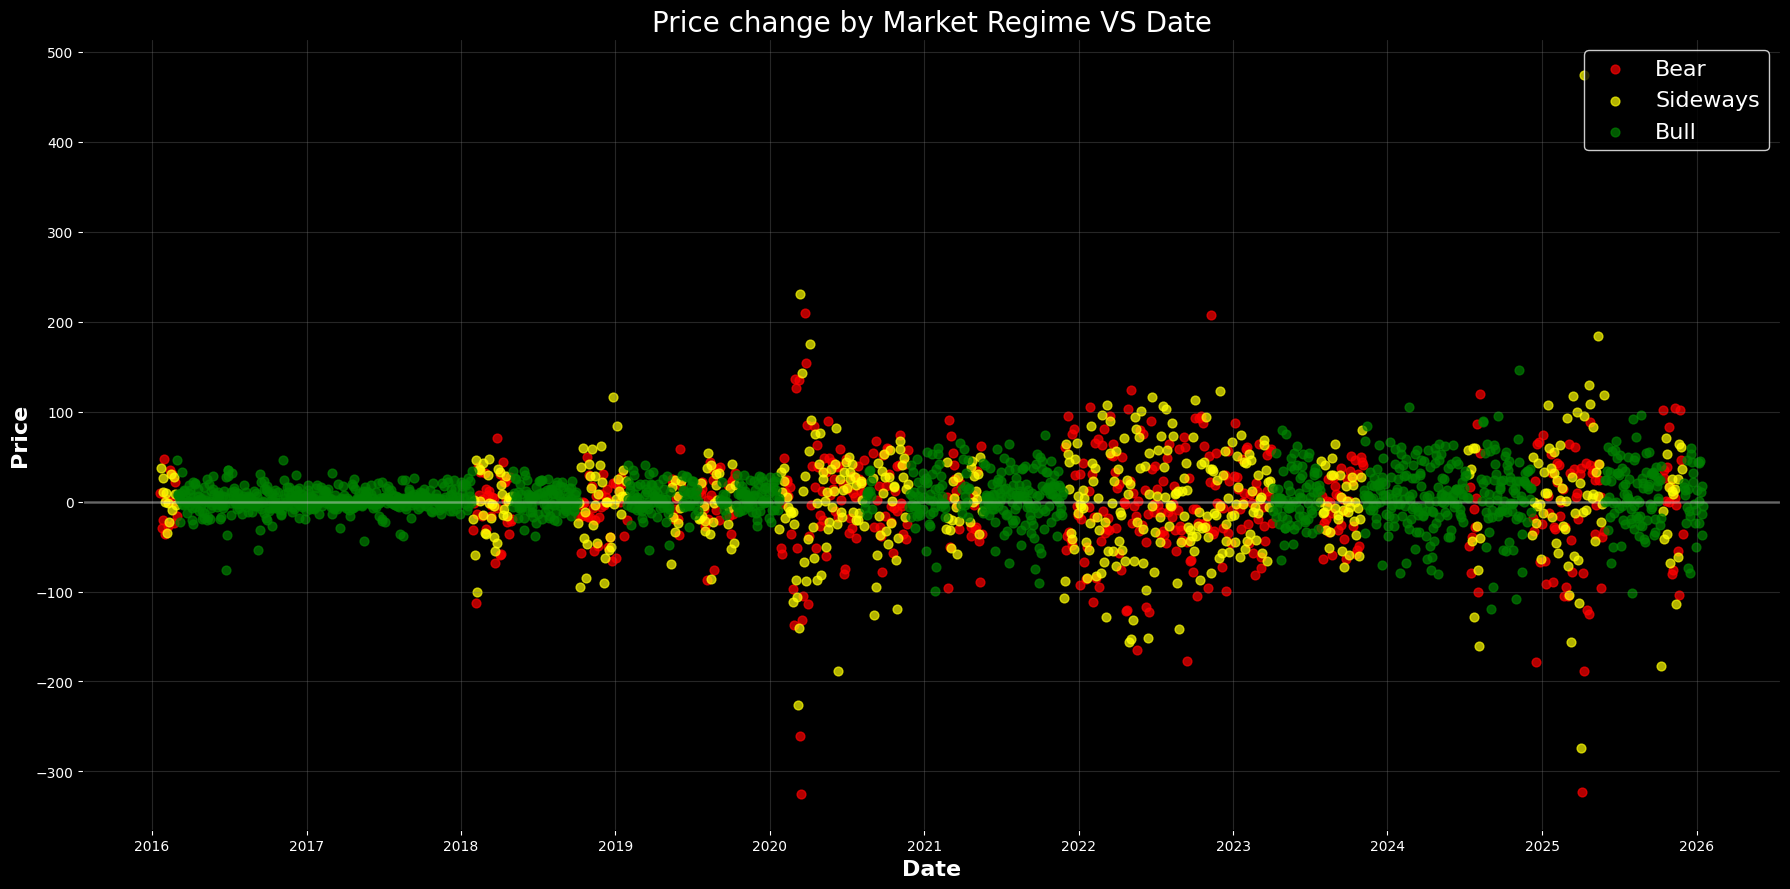

In [16]:


fig2, ax = plt.subplots(figsize=(18, 9))


fig2.patch.set_facecolor('black')
ax.set_facecolor('black')

regime_colors = ['red', 'yellow', 'green']
for regime in [0, 1, 2]:
    regime_data = price_with_regimes[price_with_regimes['Regime'] == regime]
    ax.scatter(regime_data.index, regime_data['Price_Diff'],
                color=regime_colors[regime], label=regime_labels[regime], alpha=0.7, s=40)

ax.axhline(y=0, color='white', linestyle='-', alpha=0.3, linewidth=2)
ax.set_title('Price change by Market Regime VS Date', fontsize=20, color='white')
ax.set_xlabel('Date', fontweight='bold', fontsize=16, color='white')
ax.set_ylabel('Price', fontweight='bold', fontsize=16, color='white')
ax.tick_params(axis='x', colors='white')
ax.tick_params(axis='y', colors='white')
ax.legend(fontsize=16, facecolor='black', edgecolor='white', labelcolor='white')
ax.grid(True, alpha=0.3, color='grey')

plt.tight_layout()
plt.show()